<a href="https://colab.research.google.com/github/gcilinskas/amz_review_pub/blob/main/Amazon_Fake_Review_Detector_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [99]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import warnings, string
import nltk
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [100]:
## import dataset
## source: https://osf.io/2axm3/
## https://www.sciencedirect.com/science/article/pii/S0969698921003374
df = pd.read_csv('sample_data/fake reviews dataset.csv')
df.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


In [101]:
df['length'] = df['text_'].apply(len)

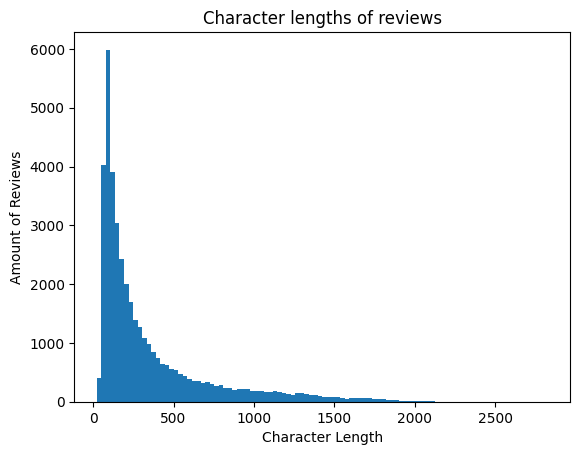

In [102]:
plt.hist(
    df['length'],
    bins=100
)

plt.xlabel('Character Length')  # Set the label for the x-axis
plt.ylabel('Amount of Reviews')  # Set the label for the y-axis
plt.title('Character lengths of reviews')

plt.show()

## CountVectorizer
**CountVectorizer** is a class in scikit-learn that converts a collection of text documents into a matrix of token counts. This is a simple but effective method to transform text into a format that can be utilized by machine learning algorithms. Each entry in the matrix indicates the frequency of a token (e.g., a word or a phrase) appearing in a specific document. This process is known as tokenization and it enables algorithms to process and analyze text data.

**Key Features of CountVectorizer**:
- Tokenization: Splits the text into individual tokens (usually words).
- Vocabulary building: Determines the vocabulary of the dataset (all unique tokens).
- Encoding: Assigns a numeric value (index) to each item in the vocabulary.
- Counting: Counts the occurrences of each token in each document.

In [103]:
def text_process(review):
    nopunc = [char for char in review if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

# Bag of Words (BoW) Model
**"BoW"** stands for **"Bag of Words"** a fundamental concept in natural language processing (NLP) and text analysis. The Bag of Words model is a way of extracting features from text for use in modeling, such as with machine learning algorithms. The idea is simple yet powerful: represent text data as a collection (or "bag") of words without considering grammar or word order but maintaining multiplicity (the number of times each word appears).

In [104]:
bow_transformer = CountVectorizer(analyzer=text_process)
bow_transformer

CountVectorizer(analyzer=<function text_process at 0x7afac838a170>)

In [105]:
bow_transformer.fit(df['text_'])
print("Total Vocabulary:" , len(bow_transformer.vocabulary_))

Total Vocabulary: 61612


In [106]:
review2 = df['text_'][1]
review2

"love it, a great upgrade from the original.  I've had mine for a couple of years"

In [107]:
bow_review_2 = bow_transformer.transform([review2])
print(bow_review_2)
print(bow_review_2.shape)

  (0, 12324)	1
  (0, 31590)	1
  (0, 38385)	1
  (0, 43408)	1
  (0, 44574)	1
  (0, 46810)	1
  (0, 59313)	1
  (0, 61421)	1
(1, 61612)


In [108]:
bow_reviews = bow_transformer.transform(df['text_'])

# What is a Sparse Matrix?
Imagine a huge grid or table, where each cell can hold a number. If most of these cells are empty (meaning they have a zero value), then this grid is what we call "sparse." A sparse matrix is precisely this: a matrix with most of its elements being zero.

Contrast this with a "dense matrix," where most of the elements are non-zero. Dense matrices are what people usually picture when they think of matrices.

# Why Use Sparse Matrices?
Sparse matrices are especially useful because storing and processing all those zeros in a dense format is highly inefficient. They allow us to save a lot of memory and computational resources by only storing information about the non-zero elements.

# How Sparse Matrices Work
A sparse matrix doesn't store zero values. Instead, it stores the location (the row and column) and the value of non-zero elements. There are several ways to represent sparse matrices, but here are two common ones:

Coordinate List (COO): This format stores a list of (row, column, value) tuples. It's great for when you're building a matrix and efficiency in adding elements is required.
Compressed Sparse Row (CSR) or Column (CSC): These formats are similar in that they compress the data to save space. CSR focuses on saving rows efficiently, while CSC focuses on columns. They're better for fast arithmetic, slicing, and matrix-vector operations.
# Sparse Matrices in NLP
In the context of NLP and text mining, when you transform text documents into numerical representations using models like Bag of Words (BoW), you end up with a very large matrix. Each row of the matrix represents a document, and each column represents a unique word from the corpus. The value in each cell shows the presence (or frequency) of the word in the document.

Given the vast number of words in a language, most documents only use a tiny subset of the language. Thus, most of the matrix cells will be zero, indicating the absence of most words in most documents. This is why sparse matrices are ideal for text data.

Example
Consider you have 1,000 documents and a vocabulary of 10,000 unique words. Each document might only use, say, 100 of those words. If you were to store this information in a dense matrix, you'd need space for 10,000,000 values (1,000 documents × 10,000 words). However, since each document only uses 100 words, you'd really only need to store 100,000 non-zero values (1,000 documents × 100 words/document). Sparse matrices make this efficiency possible.

# Understanding the Components
**bow_reviews**: This is your sparse matrix, resulting from transforming text data into a Bag of Words (BoW) format using CountVectorizer. Each row represents a document, and each column represents a unique word in vocabulary. The non-zero values in this matrix indicate the presence or frequency of the corresponding word in the respective document.

**bow_reviews.nnz**: The **.nnz** attribute of a sparse matrix returns the **Number of Non-Zero elements** present in the matrix. This gives you the total count of all entries in the matrix that are not zero.

**bow_reviews.shape**: The .shape attribute returns a tuple representing the **dimensions of the matrix** (number of rows, number of columns). In the context of bow_reviews, the number of rows corresponds to the number of documents, and the number of columns corresponds to the size of the vocabulary.

**bow_reviews.shape[0]**: This accesses the first element of the shape tuple, giving you the **number of rows (documents) in the matrix**.

**bow_reviews.shape[1]**: This accesses the second element of the shape tuple, giving you the number of **columns (unique words) in the matrix**.

# Calculating Sparsity

- **bow_reviews.shape[0]** * **bow_reviews.shape[1]**): Multiplies the number of documents by the number of unique words to find the **total number of possible entries in the matrix**.

- **bow_reviews.nnz** / (**bow_reviews.shape[0]** * **bow_reviews.shape[1]**): Divides the number of non-zero entries by the total number of possible entries to find the **proportion of entries that are non-zero**.

- **Multiplying by 100**: Converts the **proportion to a percentage**.

- **np.round(..., 2)**: **Rounds the resulting percentage to two decimal places** for readability. This rounding is done using NumPy's round function.

The Concept of Sparsity
Sparsity indicates how "empty" a matrix is. A high sparsity percentage means that the matrix has fewer non-zero elements, i.e., it is mostly empty. This is typical for text data in BoW representations, where most words in the vocabulary are not used in most documents.

In [109]:
print("Sparsity:",np.round((bow_reviews.nnz/(bow_reviews.shape[0]*bow_reviews.shape[1]))*100,2))

Sparsity: 0.04


# Why Use TF-IDF?
TF-IDF is valuable because it balances the frequency of terms within documents against their frequency across the entire corpus of documents. This helps in highlighting the importance of words within documents in a way that's more informative than mere term frequencies. For instance, words that are common in a particular document but rare across other documents tend to have higher TF-IDF scores, making them potentially more relevant for analysis or for use in machine learning models.

# Components of the Code
TfidfTransformer: This is a class from scikit-learn's feature_extraction.text module. The TfidfTransformer is designed to transform a count matrix (like the one produced by CountVectorizer, which counts occurrences of words) into a TF-IDF representation.

- **TF (Term Frequency)**: This measures how frequently a term occurs in a document. Since every document is of different length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka the total number of terms in the document) as a way of normalization.

- **IDF (Inverse Document Frequency)**: This measures how important a term is. While computing TF, all terms are considered equally important. However, certain terms, like "is", "of", and "that", may appear a lot of times but have little importance. Thus, we need to weigh down the frequent terms while scale up the rare ones, by computing the IDF, which diminishes the weight of terms that occur very frequently in the document set and increases the weight of terms that occur rarely.

- **.fit(bow_reviews)**: This method fits the TF-IDF transformer to the Bag of Words (BoW) matrix bow_reviews. By fitting the transformer to your data, it learns the IDF (Inverse Document Frequency) weights for all words in your corpus (the collection of documents). Essentially, it's preparing the transformer by calculating the necessary statistics (like the IDF) from your BoW matrix.

In [110]:
tfidf_transformer = TfidfTransformer().fit(bow_reviews)
tfidf_review_2 = tfidf_transformer.transform(bow_review_2)
tfidf_review_2

<1x61612 sparse matrix of type '<class 'numpy.float64'>'
	with 8 stored elements in Compressed Sparse Row format>

The code below is printing the Inverse Document Frequency (IDF) scores for two specific words, "apple" and "book", from a TF-IDF model represented by tfidf_transformer. These IDF scores are part of the TF-IDF (Term Frequency-Inverse Document Frequency) weighting scheme, which is used to evaluate how important a word is to a document in a collection or corpus. Here’s what each part of the code and the output means:

# Understanding the Components
**tfidf_transformer**: This is an instance of TfidfTransformer, which we fitted to the dataset (bow_reviews). It has calculated the IDF scores for all the words in the vocabulary of the dataset. The IDF score represents the importance of a word; higher scores indicate words that are rare across documents, while lower scores indicate words that are common.

**bow_transformer.vocabulary_**: This is the vocabulary learned by CountVectorizer instance (bow_transformer). It's a dictionary mapping word names to column indices.

**bow_transformer.vocabulary_['apple']**: This retrieves the column index for the word "mango" in the BoW vocabulary.

**bow_transformer.vocabulary_['book']**: Similarly, this retrieves the column index for the word "book".

**tfidf_transformer.idf_**: This attribute of the TfidfTransformer holds the array of computed IDF scores for every word in the vocabulary. Accessing this array at the index of a specific word gives you the IDF score for that word.

# The Printed Outputs
8.311564696202637: The IDF score for "apple". A high IDF score for "apple" suggests that "apple" is a relatively rare word across the documents in the corpus. It appears in fewer documents, so when it does appear, it's considered more significant for the meaning of the document.

2.9117275133827123: The IDF score for "book". A lower IDF score for "book" indicates that it's a more common word across the documents. It appears in more documents, making it less unique and therefore less significant in distinguishing one document from another in the corpus.

# Interpretation
The significant difference in IDF scores between "apple" and "book" suggests that "book" is a common term across your corpus, likely not very useful for distinguishing between documents since it appears frequently. On the other hand, "apple" is much rarer, making it potentially more valuable for identifying the specific content or topic of a document where it appears.

This concept is at the heart of TF-IDF: balancing the frequency of words within documents (Term Frequency) against their frequency across all documents (Document Frequency) to identify words that are particularly indicative of the content of each document.

In [111]:
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['apple']])
print(tfidf_transformer.idf_[bow_transformer.vocabulary_['book']])

8.311564696202637
2.9117275133827123


In [112]:
tfidf_reviews = tfidf_transformer.transform(bow_reviews)
print("Shape:",tfidf_reviews.shape)
print("No. of Dimensions:",tfidf_reviews.ndim)

Shape: (40432, 61612)
No. of Dimensions: 2


#Training and Testing

In [113]:
review_train, review_test, label_train, label_test = train_test_split(df['text_'],df['label'],test_size=0.3)

## Multinomial Naive Bayes Model



## 1. Pipeline Creation
The Pipeline object is a utility from scikit-learn that allows you to chain together multiple processing steps into a single entity, which can then be used to fit, predict, or transform data. This approach simplifies the code and helps avoid mistakes, like leaking data from your training dataset into the preprocessing steps.

## 2. Components of the Pipeline
The pipeline consists of three main components, each represented as a tuple with two elements: a string name and an instance of a transformer or estimator.

### ('bow', CountVectorizer(analyzer=text_process)):
This is the first step in the pipeline, responsible for converting text documents into a "bag-of-words" model, which is a numerical representation where each document is described by the frequency of words that appear in it. The analyzer=text_process parameter specifies that a custom function text_process should be used for preprocessing the text before converting it into vectors. This function might perform operations like tokenization, stemming, or removing stopwords.

### ('tfidf', TfidfTransformer()):
The second step applies the Term Frequency-Inverse Document Frequency (TF-IDF) transformation to the output of the CountVectorizer. TF-IDF is a technique to quantify the importance of words in a document based on how frequently they appear across multiple documents. The rationale is that words that appear frequently in a document but not across documents are more significant.

### ('classifier', MultinomialNB()):
The final step in the pipeline is a classifier, specifically a Multinomial Naive Bayes classifier. This classifier is well-suited for classification problems involving discrete features (like word counts for text classification). It will be trained on the TF-IDF vectors to predict the target variable (e.g., the category of a text document).

About Naive Bayes: https://www.youtube.com/watch?v=O2L2Uv9pdDA

In [114]:
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB())
])

In [115]:
pipeline.fit(review_train,label_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x7afac838a170>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

In [116]:
predictions = pipeline.predict(review_test)
predictions

array(['CG', 'CG', 'OR', ..., 'CG', 'CG', 'OR'], dtype='<U2')

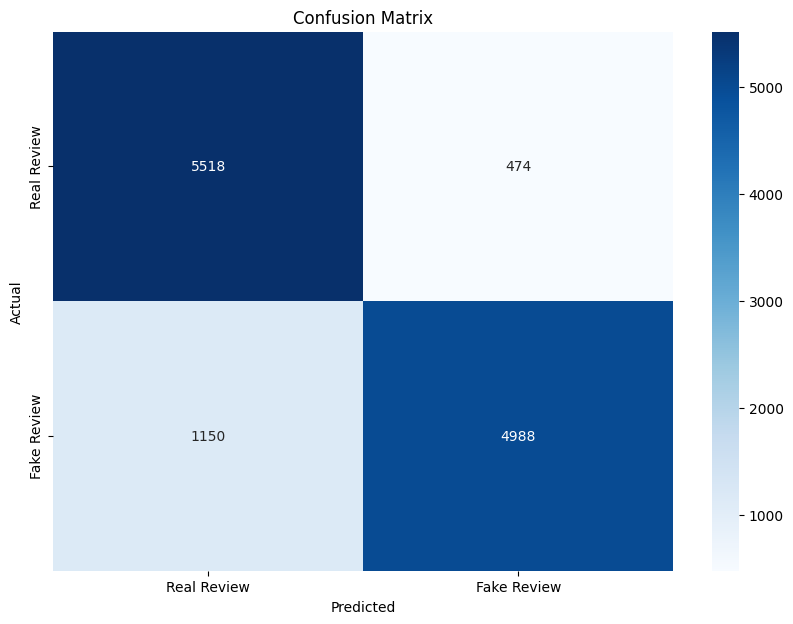

True Positives: 5518
False Positives (Identified real review as fake review): 474


In [117]:
cm = confusion_matrix(label_test, predictions)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

true_positives = cm[0][0]
false_positives = cm[0][1]

true_negatives = cm[0][1]
false_negatives = cm[1][0]

print(f'True Positives: {true_positives}')
print(f'False Positives (Identified real review as fake review): {false_positives}')


In [118]:
print('Accuracy Score:')
accuracy_score(label_test,predictions)

Accuracy Score:


0.8661170651277823

In [119]:
# Example of a random review input
example_amazon_review_1 = ["""I am 5ft 8, and not slim, but we have a couple of extended family gatherings which means a dress but summer in MN can be very humid and hot!! So thought I d try a maxi dress, I received and fit was very nice. fabric is machine washable so i did that with cold water and a few minutes in the dryer to remove wrinkles
then finished with a line dry outside. no change in size. fabric is very soft I received compliments. I will be looking for another dress for the next wedding."""]
example_amazon_review_2 = ["""Amazing dress for the price, soft, comfortable, light weight, tinsy but long but nothing a short heel can't fix when out and about. 5'4" ordered 2xl solid color and flattering to curves, drapes well
"""]
example_amazon_review_3 = ["""Fabric so soft. Easy to put on. Quality and instructions on care were included. I feel pretty and comfortable wearing this. It can be casual or dressed up. Even can consider this a lovely nightgown or lounging dress . Multiple ways you can wear and add this to your closet. Makes a great gift, Don't hesitate. A great purchase.
"""]

# Using the pipeline to predict the sentiment of the new review
# Make sure to wrap the new_review in a list if it's a single string
print(pipeline.predict(example_amazon_review_1))
print(pipeline.predict(example_amazon_review_2))
print(pipeline.predict(example_amazon_review_3))



['OR']
['CG']
['OR']


## Logistic Regression Model

In [82]:
pipeline_logistic_regression = Pipeline([
    ('bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',LogisticRegression())
])
pipeline_logistic_regression.fit(review_train,label_train)
lr_pred = pipeline_logistic_regression.predict(review_test)
lr_pred

array(['CG', 'OR', 'OR', ..., 'OR', 'CG', 'CG'], dtype=object)

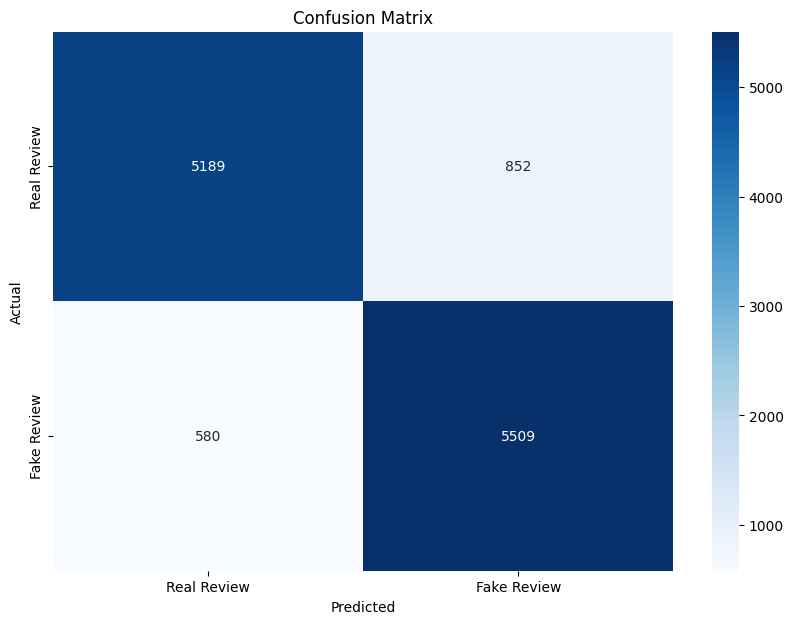

True Positives: 5189
False Negatives (Identified real review as fake review): 852


In [85]:
cm = confusion_matrix(label_test, lr_pred)

# Plotting using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Real Review', 'Fake Review'], yticklabels=['Real Review', 'Fake Review'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

true_positives = cm[0][0]
false_positives = cm[0][1]

true_negatives = cm[0][1]
false_negatives = cm[1][0]

print(f'True Positives: {true_positives}')
print(f'False Negatives (Identified real review as fake review): {false_positives}')

In [86]:
print('Accuracy Score:')
accuracy_score(label_test,lr_pred)

Accuracy Score:


0.8819455894476504

# Best Model Decision

I would choose **Multinomial Naive Bayes Model**

Even though it has less accuracy than LogisticRegression model by 0.02, MNB model have less false_positives, which means it less likely to label good review as a fake review


In [123]:
from joblib import dump
import pickle

# Assume 'pipeline' is your scikit-learn model or pipeline
with open('/home/model.pkl', 'wb') as file:
  pickle.dump(pipeline, file)

dump(pipeline, '/home/amazon_fake_review_detector_model_pipeline2.joblib')

PicklingError: Can't pickle <function text_process at 0x7afac838a170>: it's not the same object as __main__.text_process